# SMK-CAN-187 Datasets

In [1]:
from scipy.io import loadmat
data_mat = loadmat('SMK-CAN-187.mat')
data_X = data_mat['X']
data_y = data_mat['Y']
data_y = data_y.flatten()
print(data_X.shape, data_y.shape)

(187, 19993) (187,)


In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_X = scaler.fit_transform(data_X)

In [3]:
import numpy as np 
data_y[np.where(data_y==1)] = 0
data_y[np.where(data_y==2)] = 1

## No Feature Selection

In [6]:
from torch import nn
import torch
def make_models(input_dims):
    models = []
    for input_dim in input_dims:
        model = []
        if input_dim >= 512:
            model.append(nn.Linear(input_dim, 512))
            model.append(nn.ReLU())
            model = model + [nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU()]
        else:
            model = [nn.Linear(input_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU()]
        models.append(nn.Sequential(*model))
    top_model = nn.Sequential(
        nn.Linear(len(input_dims)*128, 32), nn.ReLU(True),
        nn.Linear(32, 1), nn.Sigmoid()
    )
    return models, top_model

In [7]:
import torch 
from Courier import SyncLocalCourier
from VFLDataUtils import SimpleNumpyDataLoader
from Client import SyncFNNClient
from Strategy import SyncConcatStrategy
from Server import SyncFNNServer
from Model import make_models
torch.manual_seed(0)
EMB_DIM = 128
baselines_no_fs = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_no_fs[client_num] = history    
    
    


Client 0: Feature Index 0-9996
Server : Feature Index 9997-19992
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69975 | Acc: 0.421 | Val ACC: 0.526
Epoch 001: | Loss: 0.69245 | Acc: 0.579 | Val ACC: 0.526
Epoch 002: | Loss: 0.69092 | Acc: 0.579 | Val ACC: 0.526
Epoch 003: | Loss: 0.67989 | Acc: 0.579 | Val ACC: 0.526
Epoch 004: | Loss: 0.66965 | Acc: 0.579 | Val ACC: 0.526
Epoch 005: | Loss: 0.66376 | Acc: 0.579 | Val ACC: 0.526
Epoch 006: | Loss: 0.65902 | Acc: 0.603 | Val ACC: 0.526
Epoch 007: | Loss: 0.65056 | Acc: 0.603 | Val ACC: 0.474
Epoch 008: | Loss: 0.63871 | Acc: 0.611 | Val ACC: 0.447
Epoch 009: | Loss: 0.62452 | Acc: 0.631 | Val ACC: 0.500
Epoch 010: | Loss: 0.61621 | Acc: 0.611 | Val ACC: 0.579
Epoch 011: | Loss: 0.60539 | Acc: 0.623 | Val ACC: 0.658
Epoch 012: | Loss: 0.59137 | Acc: 0.642 | Val ACC: 0.658
Epoch 013: | Loss: 0.58071 | Acc: 0.674 | Val ACC: 0.711
Epoch 014:

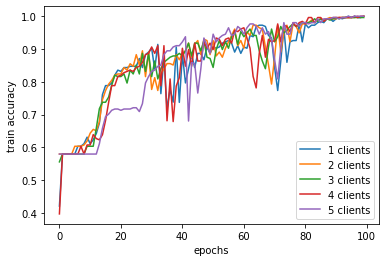

In [8]:
import matplotlib.pyplot as plt
for key, value in baselines_no_fs.items():
    x = np.arange(100)
    y = value['train-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.show()

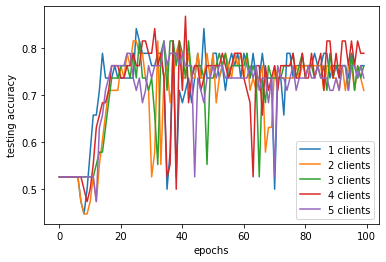

In [7]:
import matplotlib.pyplot as plt
for key, value in baselines_no_fs.items():
    x = np.arange(100)
    y = value['test-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
plt.show()


## GINI-method

In [8]:
from Gini import gini_score_fast_old
gini_score = gini_score_fast_old(
    torch.tensor(data_X), torch.tensor(data_y).to(int)
)
indices = torch.argsort(gini_score)[: int(gini_score.shape[0]/2)]
data_X_filterd = data_X[:, indices]
baselines_fs_prior_half= {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X_filterd, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_fs_prior_half[client_num] = history    

Client 0: Feature Index 0-4997
Server : Feature Index 4998-9995
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69537 | Acc: 0.421 | Val ACC: 0.526
Epoch 001: | Loss: 0.68261 | Acc: 0.579 | Val ACC: 0.526
Epoch 002: | Loss: 0.67881 | Acc: 0.579 | Val ACC: 0.526
Epoch 003: | Loss: 0.68109 | Acc: 0.579 | Val ACC: 0.526
Epoch 004: | Loss: 0.67644 | Acc: 0.579 | Val ACC: 0.526
Epoch 005: | Loss: 0.67131 | Acc: 0.579 | Val ACC: 0.526
Epoch 006: | Loss: 0.66185 | Acc: 0.579 | Val ACC: 0.526
Epoch 007: | Loss: 0.65606 | Acc: 0.579 | Val ACC: 0.526
Epoch 008: | Loss: 0.65152 | Acc: 0.603 | Val ACC: 0.526
Epoch 009: | Loss: 0.64403 | Acc: 0.603 | Val ACC: 0.526
Epoch 010: | Loss: 0.63294 | Acc: 0.587 | Val ACC: 0.526
Epoch 011: | Loss: 0.62525 | Acc: 0.635 | Val ACC: 0.474
Epoch 012: | Loss: 0.61759 | Acc: 0.650 | Val ACC: 0.500
Epoch 013: | Loss: 0.60567 | Acc: 0.702 | Val ACC: 0.526
Epoch 014: 

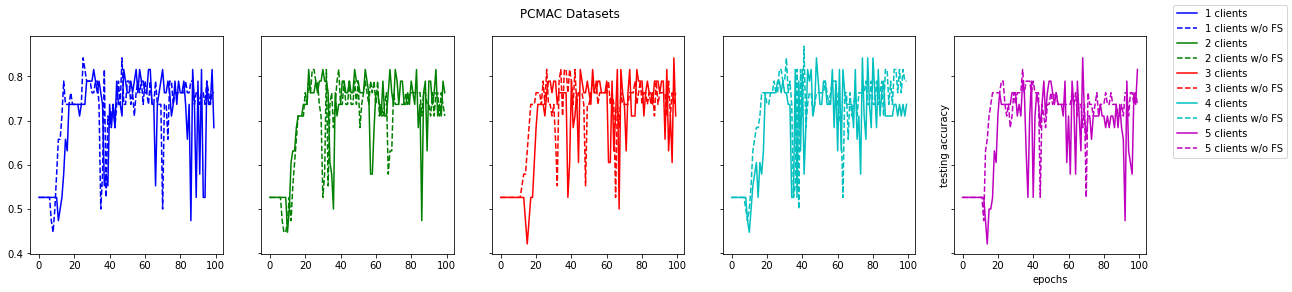

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, 
        label=f'{key} clients', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, '--',
        label=f'{key} clients w/o FS', color=colors[i]
    )

fig.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
fig.suptitle('PCMAC Datasets')
# plt.suptitle('PCMAC Datasets')
plt.show()

__This dataset is too small. Very severe overfitting__

## STG

In [9]:
from Model import make_stg_models
from Strategy import SyncSTGConcatStrategy
from Server import SyncSTGServer
import torch
torch.manual_seed(0)
EMB_DIM = 128
baselines_stg = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_stg_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncSTGConcatStrategy(courier=courier, clients=clients)
    server = SyncSTGServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
        # count number of parameters      
    history = server.get_history()
    baselines_stg[client_num] = history  

Client 0: Feature Index 0-9996
Server : Feature Index 9997-19992
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69534 | Acc: 0.397 | Val ACC: 0.526 | Features Left: 9394
Epoch 001: | Loss: 0.70102 | Acc: 0.413 | Val ACC: 0.526 | Features Left: 8931
Epoch 002: | Loss: 0.67632 | Acc: 0.579 | Val ACC: 0.526 | Features Left: 8602
Epoch 003: | Loss: 0.68126 | Acc: 0.579 | Val ACC: 0.526 | Features Left: 8320
Epoch 004: | Loss: 0.67334 | Acc: 0.579 | Val ACC: 0.526 | Features Left: 8102
Epoch 005: | Loss: 0.66178 | Acc: 0.603 | Val ACC: 0.526 | Features Left: 7969
Epoch 006: | Loss: 0.64769 | Acc: 0.603 | Val ACC: 0.526 | Features Left: 7889
Epoch 007: | Loss: 0.63877 | Acc: 0.583 | Val ACC: 0.447 | Features Left: 7846
Epoch 008: | Loss: 0.62602 | Acc: 0.635 | Val ACC: 0.553 | Features Left: 7851
Epoch 009: | Loss: 0.60471 | Acc: 0.619 | Val ACC: 0.553 | Features Left: 7871
Epoch 010: | Loss:

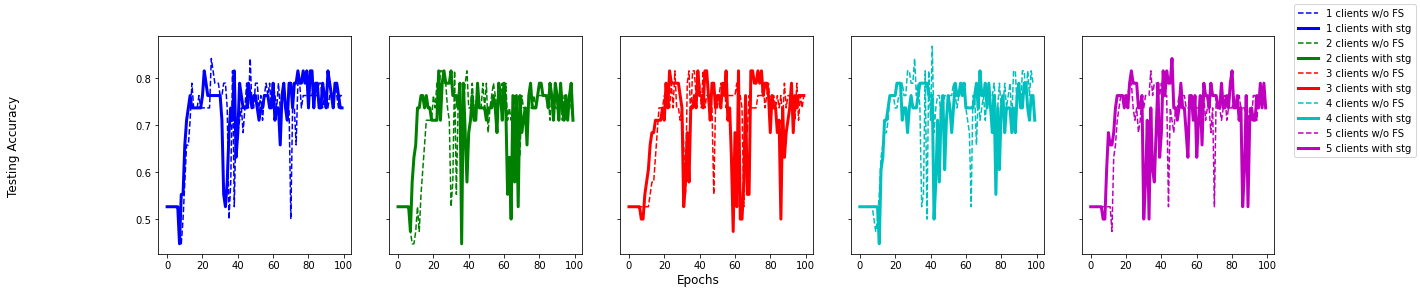

In [14]:
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True, sharex=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_stg.items()):
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, '--',
        label=f'{key} clients w/o FS', color=colors[i]
    )
    y_stg = baselines_stg[key]['test-acc']
    axs[i].plot(
        x, y_stg, linewidth=3,
        label=f'{key} clients with stg', color=colors[i]
    )
fig.legend()
fig.supxlabel('Epochs')
fig.supylabel('Testing Accuracy')
plt.show()

---

# PCMAC Datasets

In [15]:
from scipy.io import loadmat
data_mat = loadmat('PCMAC.mat')
data_X = data_mat['X']
data_X = data_X.todense()
data_y = data_mat['Y']
data_y = data_y.flatten()
scaler = MinMaxScaler()
data_X = scaler.fit_transform(data_X)
print(data_X.shape, data_y.shape)

(1943, 3289) (1943,)


In [16]:
data_y[np.where(data_y==1)] = 0
data_y[np.where(data_y==2)] = 1

In [17]:
torch.manual_seed(0)
EMB_DIM = 128
baselines_no_fs = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_no_fs[client_num] = history    
    

Client 0: Feature Index 0-1644
Server : Feature Index 1645-3288
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69089 | Acc: 0.559 | Val ACC: 0.674
Epoch 001: | Loss: 0.57165 | Acc: 0.789 | Val ACC: 0.835
Epoch 002: | Loss: 0.32698 | Acc: 0.927 | Val ACC: 0.859
Epoch 003: | Loss: 0.10592 | Acc: 0.972 | Val ACC: 0.869
Epoch 004: | Loss: 0.04587 | Acc: 0.986 | Val ACC: 0.866
Epoch 005: | Loss: 0.03242 | Acc: 0.992 | Val ACC: 0.789
Epoch 006: | Loss: 0.07735 | Acc: 0.967 | Val ACC: 0.856
Epoch 007: | Loss: 0.07669 | Acc: 0.977 | Val ACC: 0.856
Epoch 008: | Loss: 0.03325 | Acc: 0.990 | Val ACC: 0.851
Epoch 009: | Loss: 0.01313 | Acc: 0.998 | Val ACC: 0.856
Epoch 010: | Loss: 0.00817 | Acc: 0.999 | Val ACC: 0.853
Epoch 011: | Loss: 0.00481 | Acc: 0.999 | Val ACC: 0.856
Epoch 012: | Loss: 0.00435 | Acc: 0.999 | Val ACC: 0.856
Epoch 013: | Loss: 0.00412 | Acc: 0.999 | Val ACC: 0.859
Epoch 014: 

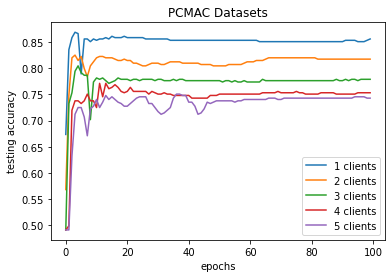

In [18]:
import matplotlib.pyplot as plt
for key, value in baselines_no_fs.items():
    x = np.arange(100)
    y = value['test-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
plt.title('PCMAC Datasets')
plt.show()


## Gini method


In [19]:
from Gini import gini_score_fast_old
gini_score = gini_score_fast_old(
    torch.tensor(data_X), torch.tensor(data_y).to(int)
)
indices = torch.argsort(gini_score)[: int(gini_score.shape[0]/2)]
data_X_filterd = data_X[:, indices]
baselines_fs_prior_half= {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X_filterd, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_fs_prior_half[client_num] = history    

Client 0: Feature Index 0-821
Server : Feature Index 822-1643
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69293 | Acc: 0.481 | Val ACC: 0.509
Epoch 001: | Loss: 0.66088 | Acc: 0.724 | Val ACC: 0.751
Epoch 002: | Loss: 0.47366 | Acc: 0.847 | Val ACC: 0.815
Epoch 003: | Loss: 0.25540 | Acc: 0.885 | Val ACC: 0.810
Epoch 004: | Loss: 0.18734 | Acc: 0.915 | Val ACC: 0.805
Epoch 005: | Loss: 0.18264 | Acc: 0.924 | Val ACC: 0.807
Epoch 006: | Loss: 0.18481 | Acc: 0.912 | Val ACC: 0.746
Epoch 007: | Loss: 0.21685 | Acc: 0.891 | Val ACC: 0.792
Epoch 008: | Loss: 0.11781 | Acc: 0.949 | Val ACC: 0.784
Epoch 009: | Loss: 0.09470 | Acc: 0.961 | Val ACC: 0.805
Epoch 010: | Loss: 0.06933 | Acc: 0.971 | Val ACC: 0.805
Epoch 011: | Loss: 0.05714 | Acc: 0.976 | Val ACC: 0.812
Epoch 012: | Loss: 0.04701 | Acc: 0.981 | Val ACC: 0.817
Epoch 013: | Loss: 0.04166 | Acc: 0.980 | Val ACC: 0.817
Epoch 014: | 

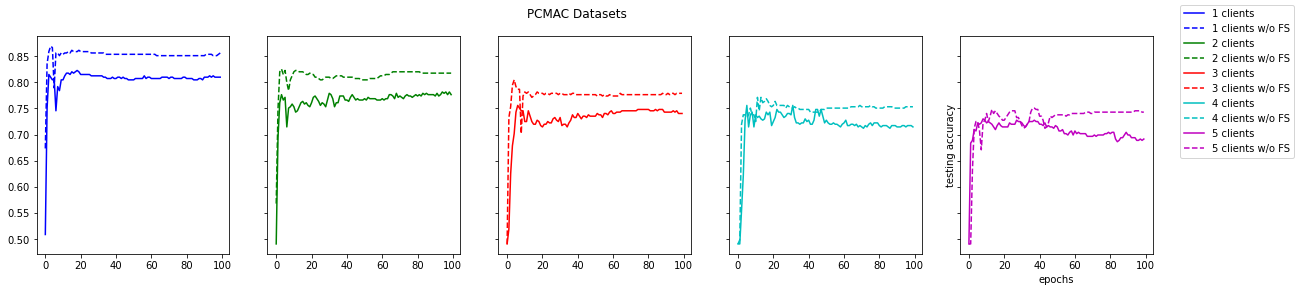

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, 
        label=f'{key} clients', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, '--',
        label=f'{key} clients w/o FS', color=colors[i]
    )

fig.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
fig.suptitle('PCMAC Datasets')
# plt.suptitle('PCMAC Datasets')
plt.show()

## STG

In [21]:
from Model import make_stg_models
from Strategy import SyncSTGConcatStrategy
from Server import SyncSTGServer
import torch
torch.manual_seed(0)
EMB_DIM = 128
baselines_stg = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_stg_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncSTGConcatStrategy(courier=courier, clients=clients)
    server = SyncSTGServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
        # count number of parameters      
    history = server.get_history()
    baselines_stg[client_num] = history  

Client 0: Feature Index 0-1644
Server : Feature Index 1645-3288
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.69325 | Acc: 0.497 | Val ACC: 0.491 | Features Left: 1033
Epoch 001: | Loss: 0.62684 | Acc: 0.800 | Val ACC: 0.730 | Features Left: 989
Epoch 002: | Loss: 0.32666 | Acc: 0.881 | Val ACC: 0.841 | Features Left: 1113
Epoch 003: | Loss: 0.12500 | Acc: 0.950 | Val ACC: 0.861 | Features Left: 1202
Epoch 004: | Loss: 0.06170 | Acc: 0.980 | Val ACC: 0.802 | Features Left: 1224
Epoch 005: | Loss: 0.10522 | Acc: 0.954 | Val ACC: 0.851 | Features Left: 1249
Epoch 006: | Loss: 0.06576 | Acc: 0.973 | Val ACC: 0.859 | Features Left: 1262
Epoch 007: | Loss: 0.02700 | Acc: 0.993 | Val ACC: 0.853 | Features Left: 1283
Epoch 008: | Loss: 0.01312 | Acc: 0.998 | Val ACC: 0.848 | Features Left: 1287
Epoch 009: | Loss: 0.00789 | Acc: 0.999 | Val ACC: 0.848 | Features Left: 1278
Epoch 010: | Loss: 0

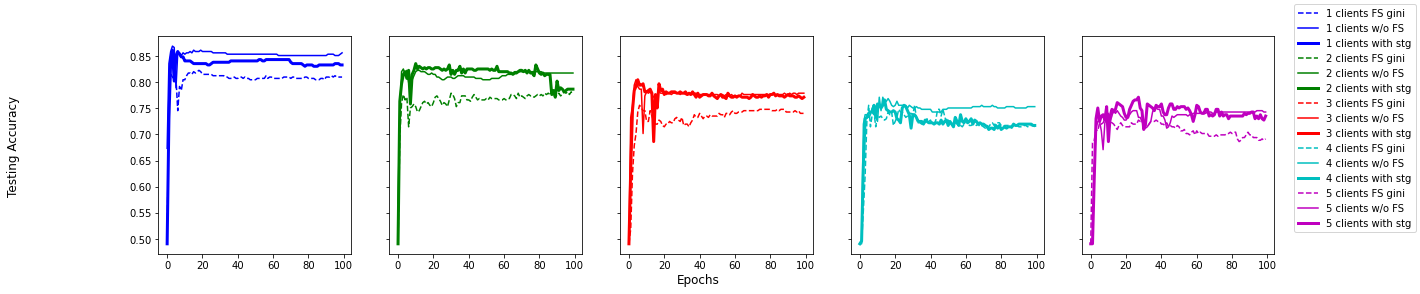

In [22]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True, sharex=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, '--',
        label=f'{key} clients FS gini', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, 
        label=f'{key} clients w/o FS', color=colors[i]
    )
    y_stg = baselines_stg[key]['test-acc']
    axs[i].plot(
        x, y_stg, linewidth=3,
        label=f'{key} clients with stg', color=colors[i]
    )

fig.legend()
fig.supxlabel('Epochs')
fig.supylabel('Testing Accuracy')
plt.show()

# GLI 85

In [24]:
from scipy.io import loadmat
data_mat = loadmat('GLI-85.mat')
data_X = data_mat['X']
# data_X = data_X.todense()
data_y = data_mat['Y']
data_y = data_y.flatten()
scaler = MinMaxScaler()
data_X = scaler.fit_transform(data_X)
print(data_X.shape, data_y.shape)

(85, 22283) (85,)


In [26]:
data_y[np.where(data_y==1)] = 0
data_y[np.where(data_y==2)] = 1

In [27]:
torch.manual_seed(0)
EMB_DIM = 128
baselines_no_fs = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_no_fs[client_num] = history    
    

Client 0: Feature Index 0-11141
Server : Feature Index 11142-22282
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.66749 | Acc: 0.706 | Val ACC: 0.647
Epoch 001: | Loss: 0.61166 | Acc: 0.706 | Val ACC: 0.647
Epoch 002: | Loss: 0.65775 | Acc: 0.706 | Val ACC: 0.647
Epoch 003: | Loss: 0.57000 | Acc: 0.706 | Val ACC: 0.647
Epoch 004: | Loss: 0.59746 | Acc: 0.706 | Val ACC: 0.647
Epoch 005: | Loss: 0.55873 | Acc: 0.706 | Val ACC: 0.647
Epoch 006: | Loss: 0.53142 | Acc: 0.706 | Val ACC: 0.647
Epoch 007: | Loss: 0.51263 | Acc: 0.706 | Val ACC: 0.647
Epoch 008: | Loss: 0.48008 | Acc: 0.706 | Val ACC: 0.647
Epoch 009: | Loss: 0.44327 | Acc: 0.706 | Val ACC: 0.647
Epoch 010: | Loss: 0.40966 | Acc: 0.706 | Val ACC: 0.647
Epoch 011: | Loss: 0.36592 | Acc: 0.750 | Val ACC: 0.647
Epoch 012: | Loss: 0.33774 | Acc: 0.824 | Val ACC: 0.824
Epoch 013: | Loss: 0.30096 | Acc: 0.941 | Val ACC: 0.882
Epoch 01

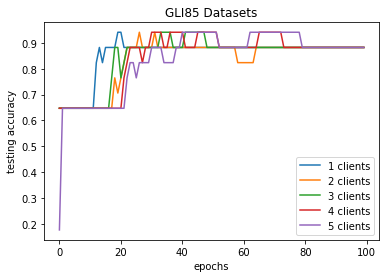

In [30]:
import matplotlib.pyplot as plt
for key, value in baselines_no_fs.items():
    x = np.arange(100)
    y = value['test-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
plt.title('GLI85 Datasets')
plt.show()


## Gini-Method

In [29]:
from Gini import gini_score_fast_old
gini_score = gini_score_fast_old(
    torch.tensor(data_X), torch.tensor(data_y).to(int)
)
indices = torch.argsort(gini_score)[: int(gini_score.shape[0]/2)]
data_X_filterd = data_X[:, indices]
baselines_fs_prior_half= {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X_filterd, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_fs_prior_half[client_num] = history    

Client 0: Feature Index 0-5570
Server : Feature Index 5571-11140
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.71022 | Acc: 0.294 | Val ACC: 0.529
Epoch 001: | Loss: 0.69272 | Acc: 0.603 | Val ACC: 0.647
Epoch 002: | Loss: 0.64578 | Acc: 0.706 | Val ACC: 0.647
Epoch 003: | Loss: 0.60726 | Acc: 0.706 | Val ACC: 0.647
Epoch 004: | Loss: 0.62332 | Acc: 0.706 | Val ACC: 0.647
Epoch 005: | Loss: 0.61722 | Acc: 0.706 | Val ACC: 0.647
Epoch 006: | Loss: 0.59236 | Acc: 0.706 | Val ACC: 0.647
Epoch 007: | Loss: 0.58294 | Acc: 0.706 | Val ACC: 0.647
Epoch 008: | Loss: 0.58127 | Acc: 0.706 | Val ACC: 0.647
Epoch 009: | Loss: 0.57465 | Acc: 0.706 | Val ACC: 0.647
Epoch 010: | Loss: 0.56212 | Acc: 0.706 | Val ACC: 0.647
Epoch 011: | Loss: 0.54693 | Acc: 0.706 | Val ACC: 0.647
Epoch 012: | Loss: 0.53328 | Acc: 0.706 | Val ACC: 0.647
Epoch 013: | Loss: 0.52008 | Acc: 0.706 | Val ACC: 0.647
Epoch 014:

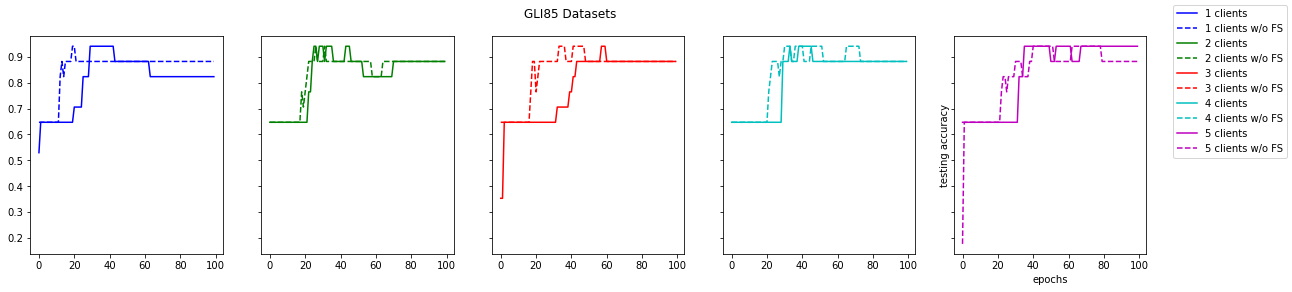

In [31]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, 
        label=f'{key} clients', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, '--',
        label=f'{key} clients w/o FS', color=colors[i]
    )

fig.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
fig.suptitle('GLI85 Datasets')
# plt.suptitle('PCMAC Datasets')
plt.show()

## STG

In [32]:
from Model import make_stg_models
from Strategy import SyncSTGConcatStrategy
from Server import SyncSTGServer
import torch
torch.manual_seed(0)
EMB_DIM = 128
baselines_stg = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(data_X, data_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_stg_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncSTGConcatStrategy(courier=courier, clients=clients)
    server = SyncSTGServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
        # count number of parameters      
    history = server.get_history()
    baselines_stg[client_num] = history  

Client 0: Feature Index 0-11141
Server : Feature Index 11142-22282
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.71495 | Acc: 0.294 | Val ACC: 0.647 | Features Left: 10897
Epoch 001: | Loss: 0.66058 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10948
Epoch 002: | Loss: 0.61022 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10799
Epoch 003: | Loss: 0.60394 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10600
Epoch 004: | Loss: 0.57507 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10470
Epoch 005: | Loss: 0.56658 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10406
Epoch 006: | Loss: 0.54017 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10390
Epoch 007: | Loss: 0.50909 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10350
Epoch 008: | Loss: 0.47828 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10333
Epoch 009: | Loss: 0.43008 | Acc: 0.706 | Val ACC: 0.647 | Features Left: 10327
Epoch 

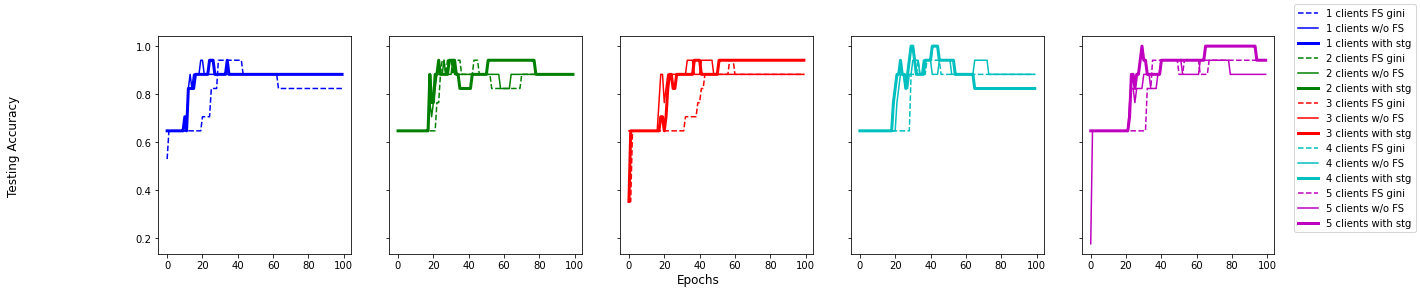

In [33]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True, sharex=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, '--',
        label=f'{key} clients FS gini', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, 
        label=f'{key} clients w/o FS', color=colors[i]
    )
    y_stg = baselines_stg[key]['test-acc']
    axs[i].plot(
        x, y_stg, linewidth=3,
        label=f'{key} clients with stg', color=colors[i]
    )

fig.legend()
fig.supxlabel('Epochs')
fig.supylabel('Testing Accuracy')
plt.show()